# **Part 1: Heart Disease Prediction**

## Preparation

In [63]:
## basic packages
import pandas as pd
import numpy as np
import math
from IPython.display import display
import warnings
import os
import torch
import random

In [64]:
## setup
warnings.filterwarnings("ignore")

## Random Seeds for reproducibility
np.random.seed(42)
torch.manual_seed(0)
random.seed(0)

## load data
train_data = pd.read_csv(os.path.join(".", "train_val_split.csv"))
test_data = pd.read_csv(os.path.join(".", "test_split.csv"))

## **Q1: Exploratory Data Analysis**

### Basic checks

In [7]:
## examine some rows
train_data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
2,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
3,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
4,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0


In [8]:
## check dataset sample size & dimensionality
n = len(train_data)
p = len(train_data.columns) - 1
print("No. of samples: ", n)
print("No. of features:", p)

No. of samples:  734
No. of features: 11


In [9]:
## check for missing data
missing_values = train_data.isnull().sum()

print("Missing values:\n")
missing_values

Missing values:



Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

### Data types and distributions of variables

In [10]:
## explore feature data types
train_data.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

*FastingBS* and *HeartDisease* are binary, hence change to data type "object" for plotting.

In [11]:
## change data type of categorical variables to "object"
train_data["FastingBS"] = train_data["FastingBS"].astype("object")
train_data["HeartDisease"] = train_data["HeartDisease"].astype("object")

In [12]:
# save variable & names
var_names = train_data.columns.tolist()
fts_names = train_data.drop("HeartDisease", axis=1).columns.tolist()
num_fts = train_data.drop("HeartDisease", axis=1).select_dtypes(exclude="object").columns.tolist()
cat_fts = train_data.drop("HeartDisease", axis=1).select_dtypes(include="object").columns.tolist()
num_vars = train_data.select_dtypes(include="int64").columns.tolist()
cat_vars = train_data.select_dtypes(include="object").columns.tolist()

In [13]:
# summary statistics
num_summary = train_data[num_fts].describe().round(2)
cat_summary = train_data[cat_fts].describe()

print("Summary statistics of continuous features:")
display(num_summary)

print("\nSummary statistics of categorical features:")
display(cat_summary)

Summary statistics of continuous features:


,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
count,734.00,734.00,734.00,734.00,734.00
mean,53.52,132.06,197.59,136.17,0.87
std,9.42,18.62,108.98,25.33,1.08
min,29.00,0.00,0.00,60.00,-2.00
25%,47.00,120.00,172.25,120.00,0.00
50%,54.00,130.00,222.00,138.00,0.50
75%,60.00,140.00,267.00,155.00,1.50
max,77.00,200.00,529.00,195.00,6.20



Summary statistics of categorical features:


,Sex,ChestPainType,FastingBS,RestingECG,ExerciseAngina,ST_Slope
count,734,734,734,734,734,734
unique,2,4,2,3,2,3
top,M,ASY,0,Normal,N,Flat
freq,573,381,563,440,439,364


<AxesSubplot:xlabel='HeartDisease', ylabel='count'>

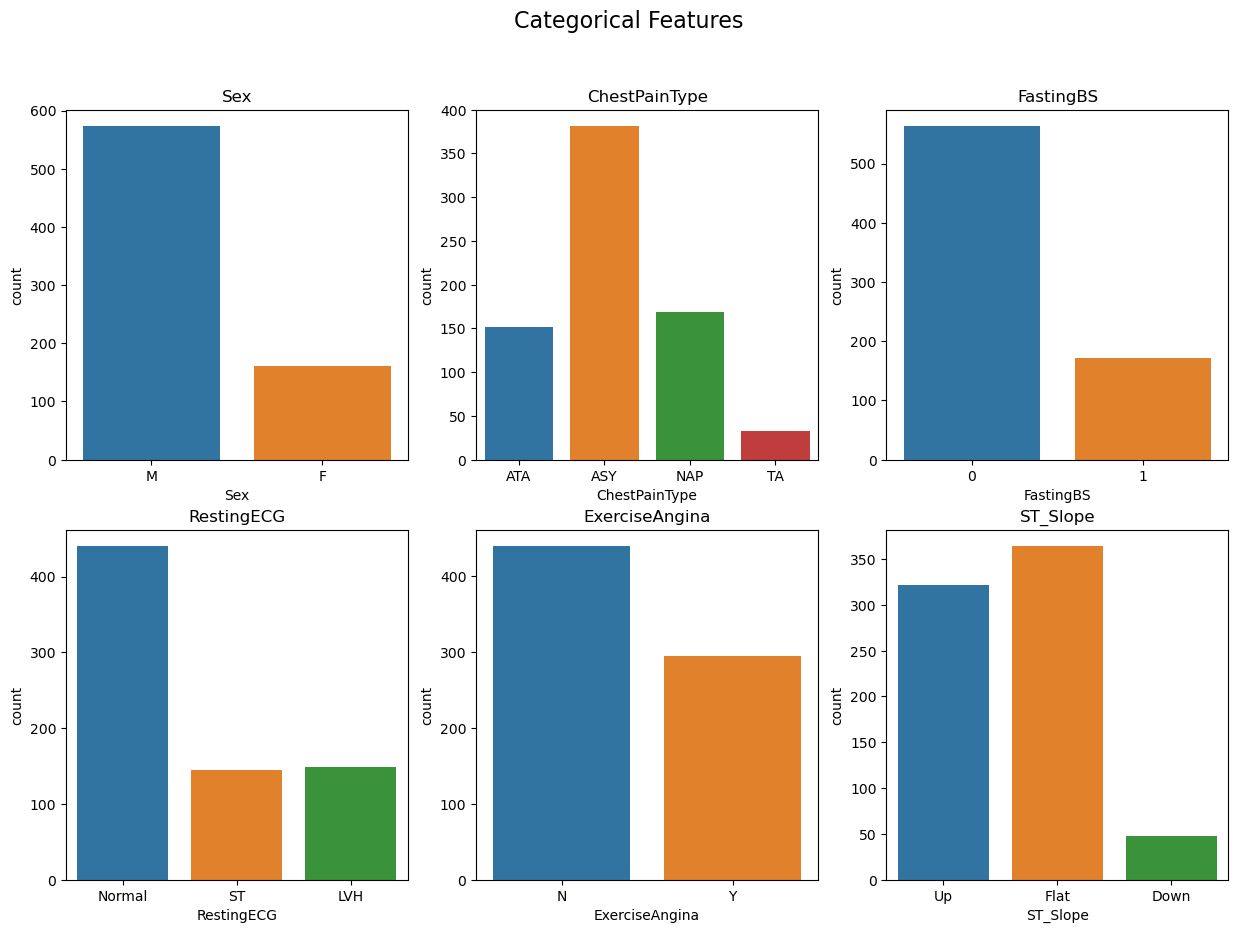

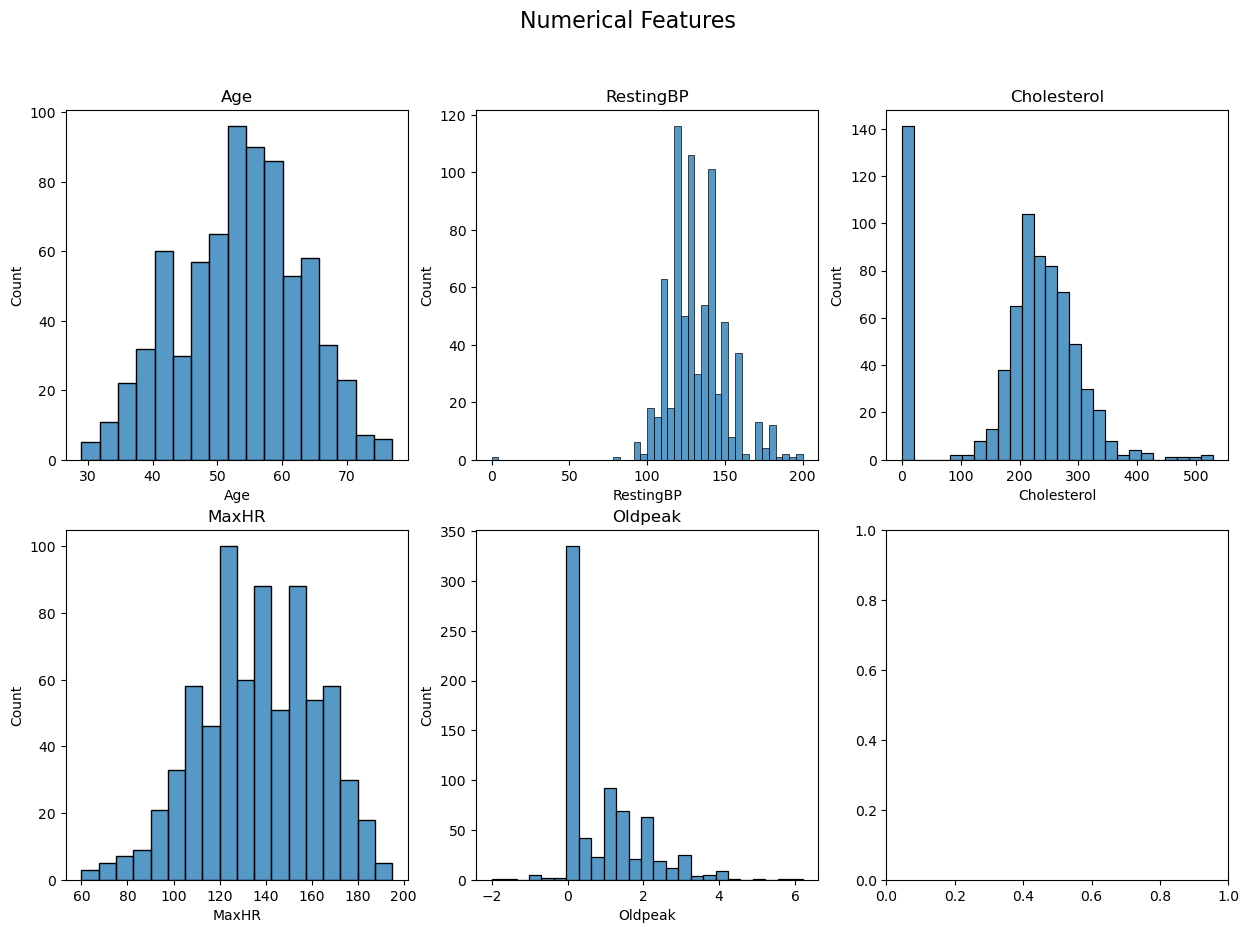

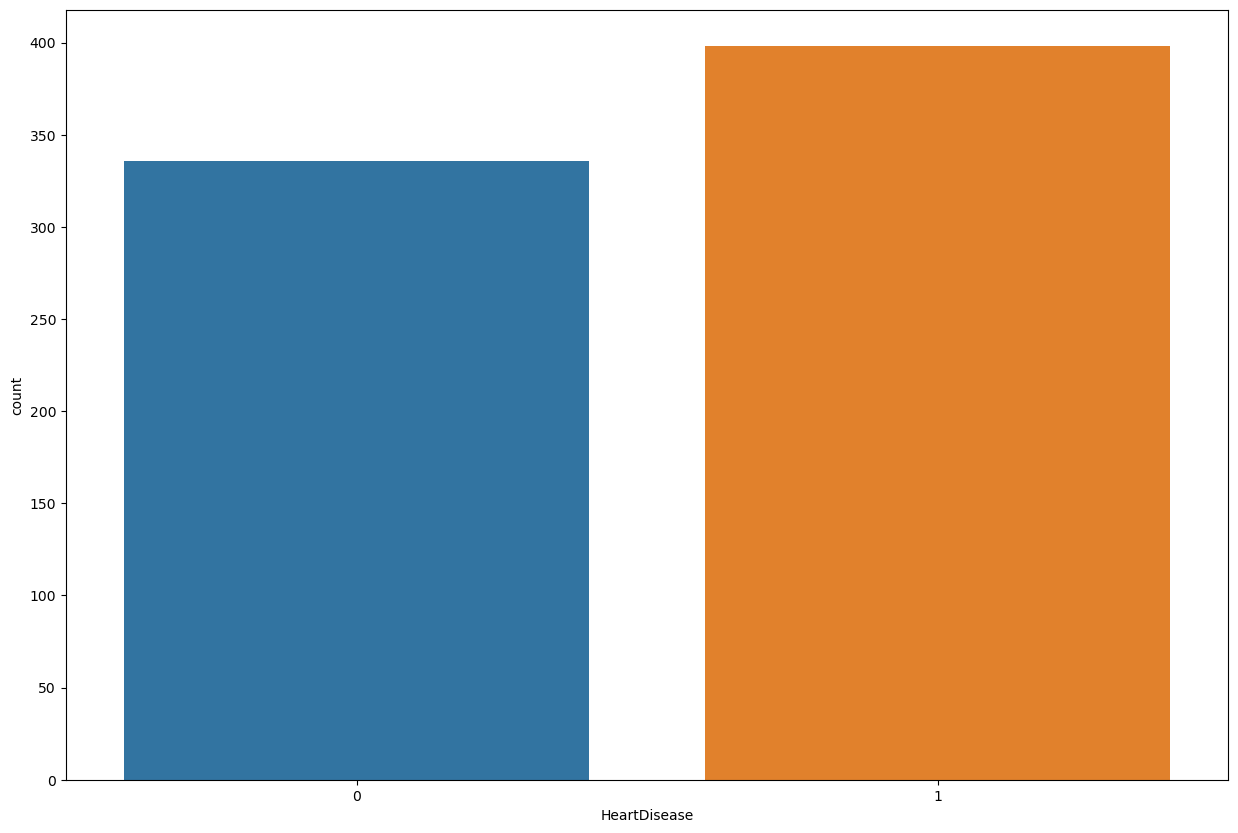

In [14]:
## plot distributions of features

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('default')

# categorical features
fig, axs = plt.subplots(2, math.ceil(len(cat_fts)/2), figsize=(15, 10))
fig.suptitle('Categorical Features', fontsize=16)
for i, col in enumerate(cat_fts):
    ax = axs.reshape(-1)[i]
    ax.set_title(col)
    sns.countplot(x=col, data=train_data, ax=ax)

# numerical features
fig, axs = plt.subplots(2, math.ceil(len(num_fts)/2), figsize=(15, 10))
fig.suptitle('Numerical Features', fontsize=16)
for i, col in enumerate(num_fts):
    ax = axs.reshape(-1)[i]
    ax.set_title(col)
    sns.histplot(x=col, data=train_data, ax=ax)

# HeartDisease Plot
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
ax = axs
sns.countplot(x="HeartDisease", data=train_data, ax=ax)

In [15]:
print("0s in RestingBP:")
print(" - Train Data: ", (train_data["RestingBP"] == 0).sum())
print(" - Test Data:  ", (test_data["RestingBP"] == 0).sum(), "\n")

print("0s in Cholesterol:")
print(" - Train Data: ", (train_data["Cholesterol"] == 0).sum())
print(" - Test Data:  ", (test_data["Cholesterol"] == 0).sum(), "\n")

print("0s in Oldpeak:")
print(" - Train Data: ", (train_data["Oldpeak"] == 0).sum())
print(" - Test Data:  ", (test_data["Oldpeak"] == 0).sum())

0s in RestingBP:
 - Train Data:  1
 - Test Data:   0 

0s in Cholesterol:
 - Train Data:  141
 - Test Data:   31 

0s in Oldpeak:
 - Train Data:  305
 - Test Data:   63


**Conclusions:**

1.   Some features are categorical, i.e. lack interpretability of differences in or ordering of their values.
2.   The dataset is imbalanced w.r.t. a couple of features, incl. *sex*, *chest pain type*, and *fasting blood sugar*. Importantly, however, the dataset is balanced w.r.t. the outcome variable, *heart disease*.
3.   *Cholesterol:* Many values of are exactly 0. Since virtually all values above 0 are >100, this seems highly unrealistic.
4.   *Oldpeak:* Again, many values are exactly 0. Yet, this lies within the range of the other observations, and hence we do not have the same suspicion for missing values.
5.   *RestingBP:* There exist an observation with resting blood pressure of 0, which seems highly unrealistic.

**Implications:**

1.   Create dummy variables or use one-hot encoding for the respective features.
2.   Be more cautious about results.
3.   As cholesterol values of 0 are highly unrealistic, we interpret this as missing values and impute them. Further, we create a dummy for this occurrence.
4.   Since we do not have enough reason to believe they are missing values, but the high frequency of 0 values still raises suspicion, we leave the values, but create a dummy for 0 entries.
4.   Since there is only 1 observation with this anomaly, ...

## EDA Preprocessing

For the purpose of EDA, our preprocessing pipeline consists of the following steps:

1.   Create dummy variable for *Cholesterol = 0*
2.   Mark *Cholesterol* as *NA* whenever it is 0
2.   Create dummy variables for categories

The corresponding dataset is called "train_proc_1"/"test_proc_1"

In [16]:
## mark all Cholesterol=0 as NA
train_data["Cholesterol"].replace(0, np.nan, inplace=True)
test_data["Cholesterol"].replace(0, np.nan, inplace=True)

# add dummy for Cholesterol=0
train_data.insert(loc=5, column="Chol_NA", value=train_data["Cholesterol"].isna()*1)
test_data.insert(loc=5, column="Chol_NA", value=test_data["Cholesterol"].isna()*1)

# add dummy for Oldpeak=0
train_data.insert(loc=11, column="Oldpeak_0", value=(train_data["Oldpeak"]==0)*1)
test_data.insert(loc=11, column="Oldpeak_0", value=(test_data["Oldpeak"]==0)*1)

The following intermediate data processing steps are mostly for exploratory data analysis only:

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# pipeline for categorical features
cat_transformer = Pipeline(steps=[("encoder", OneHotEncoder(drop=None))])

# preprocessor
preprocessing = ColumnTransformer(transformers = [("pass", "passthrough", ["HeartDisease", "Chol_NA", "Oldpeak_0"] + num_fts),
                                                  ("drop", "drop", fts_names),
                                                  ("cat", cat_transformer, cat_fts)],
                                  remainder = "passthrough")

In [18]:
## apply preprocessing pipeline to data
train_proc_1 = preprocessing.fit_transform(train_data)
test_proc_1 = preprocessing.fit_transform(test_data)

var_names = preprocessing.get_feature_names_out().tolist()
var_names = [var_names[i].replace("pass__", "").replace("num__", "").replace("cat__", "") for i in range(len(var_names))]
ft_names = var_names.copy()
ft_names.remove("HeartDisease")

train_proc_1 = pd.DataFrame(train_proc_1, columns=var_names)
test_proc_1 = pd.DataFrame(test_proc_1, columns=var_names)

In [19]:
## set numerical features to float, categorical to int
train_proc_1[num_fts] = train_proc_1[num_fts].astype("float64")
test_proc_1[num_fts] = test_proc_1[num_fts].astype("float64")

train_proc_1.loc[:, ~train_proc_1.columns.isin(num_fts)] = train_proc_1.loc[:, ~train_proc_1.columns.isin(num_fts)].astype("int64")
test_proc_1.loc[:, ~test_proc_1.columns.isin(num_fts)] = test_proc_1.loc[:, ~test_proc_1.columns.isin(num_fts)].astype("int64")

## Dependencies

We examine how the distributions of the (originally given) features depend on heart disease.

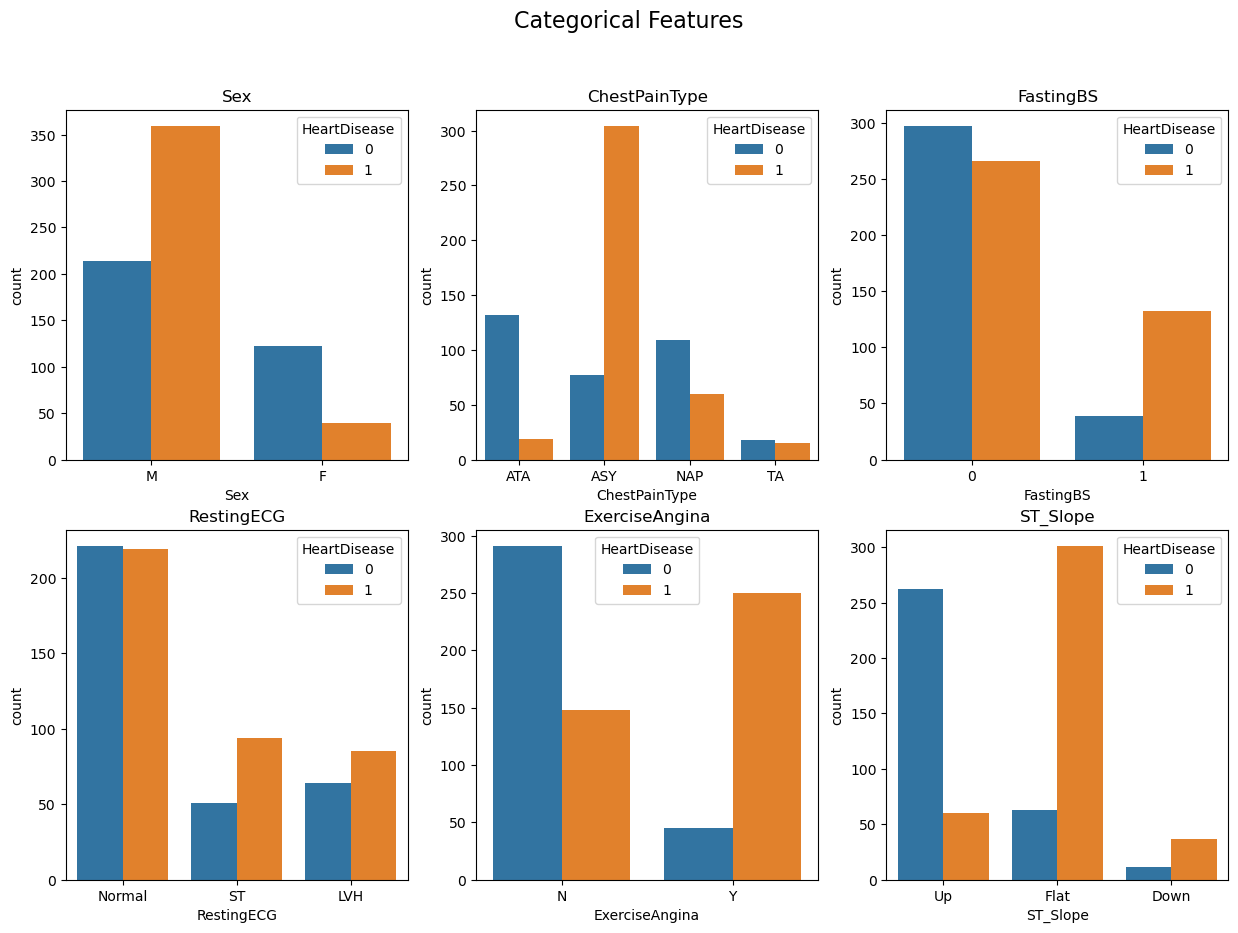

<Figure size 2000x1000 with 0 Axes>

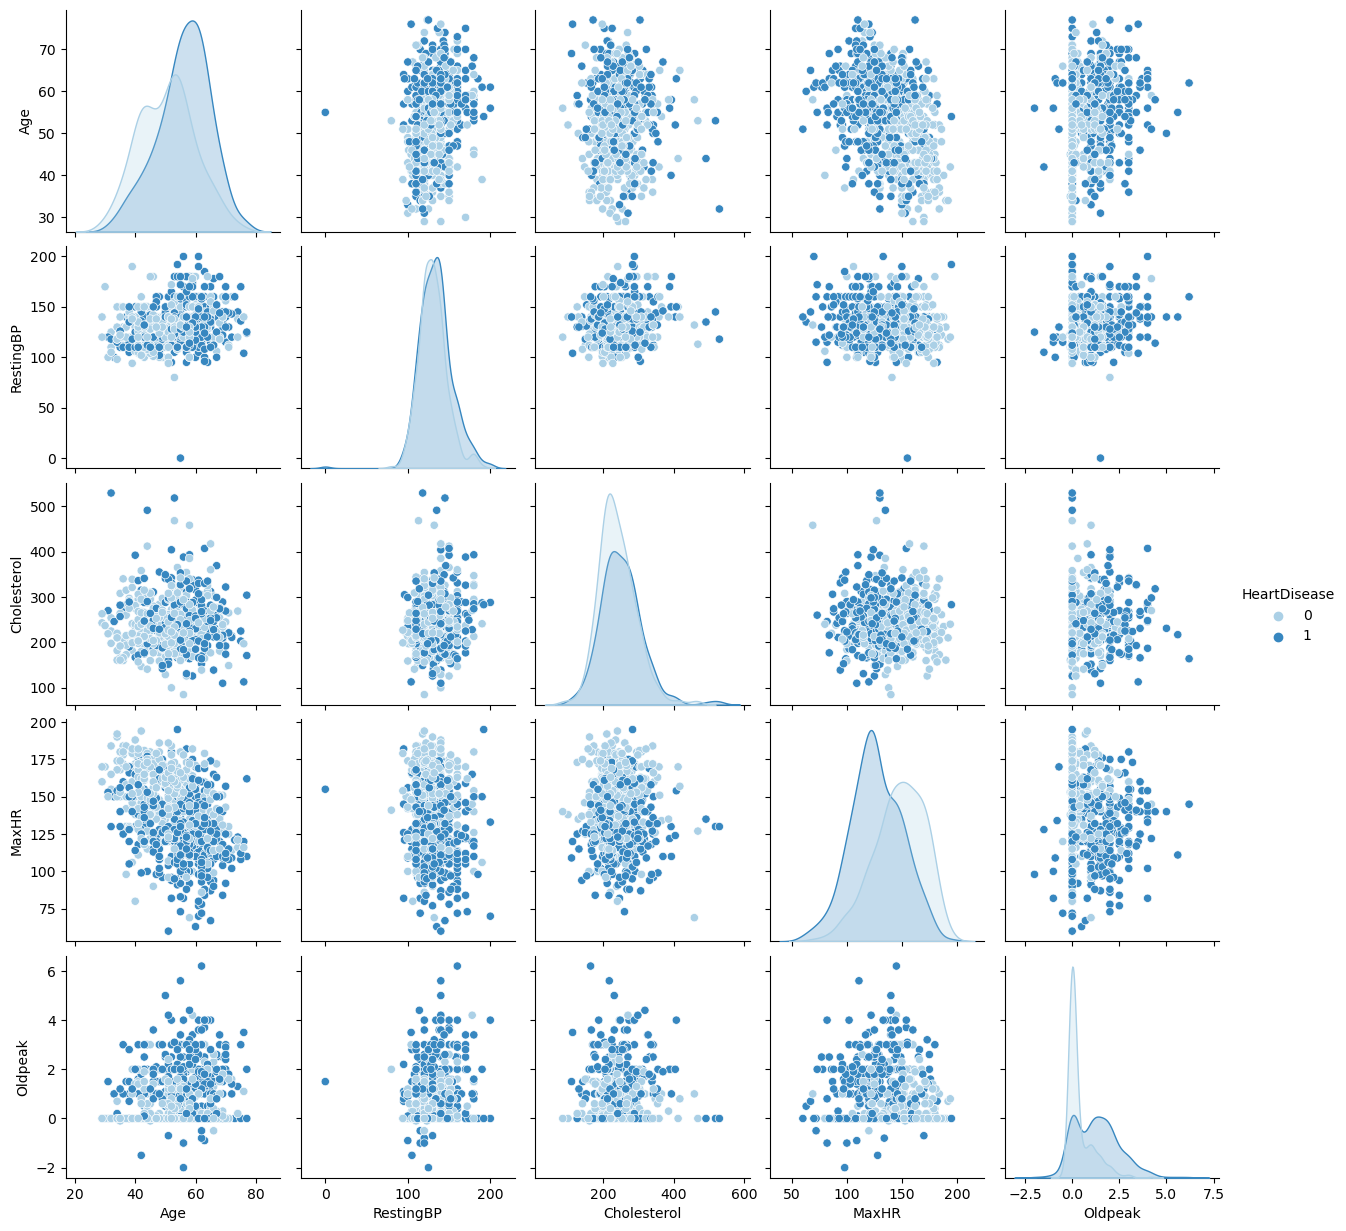

In [20]:
## plot conditional feature distributions given label

# HeartDisease & categorical features
fig, axs = plt.subplots(2, math.ceil(len(cat_fts)/2), figsize=(15, 10))
fig.suptitle('Categorical Features', fontsize=16)
for i, col in enumerate(cat_fts):
    ax = axs.reshape(-1)[i]
    ax.set_title(col)
    sns.countplot(x=train_data[col], data=train_proc_1, ax=ax, hue="HeartDisease")

# HeartDisease & continuous features
figure = plt.figure(figsize=(20,10))
figure.suptitle('Continuous Features', fontsize=16)
sns.pairplot(train_data[num_fts + ["HeartDisease"]], hue='HeartDisease', palette='Blues')

In [21]:
## define default variables and drop their dummy

default_vars = ["Sex_M",
                "ChestPainType_ASY",
                "FastingBS_0",
                "RestingECG_Normal",
                "ExerciseAngina_N",
                "ST_Slope_Up"]

To examine dependencies, we remove the collinearity and drop one category of each categorical variable. Note the definition of the "default" values of categorical features:
*   *HeartDisease:* 0
*   *Sex*: M
*   *ChestPainType:* ASY
*   *FastingBS:* 0
*   *RestingECG:* Normal
*   *ExerciseAngina:* N
*   *ST_Slope:* Flat

We compute rank correlations between non-categorical variables, since these can capture also non-linear (monotonic) dependence structures. In case of binary variables (which includes the outcome variable *HeartDisease*), it corresponds to linear correlation.

Rank correlation:


<AxesSubplot:>

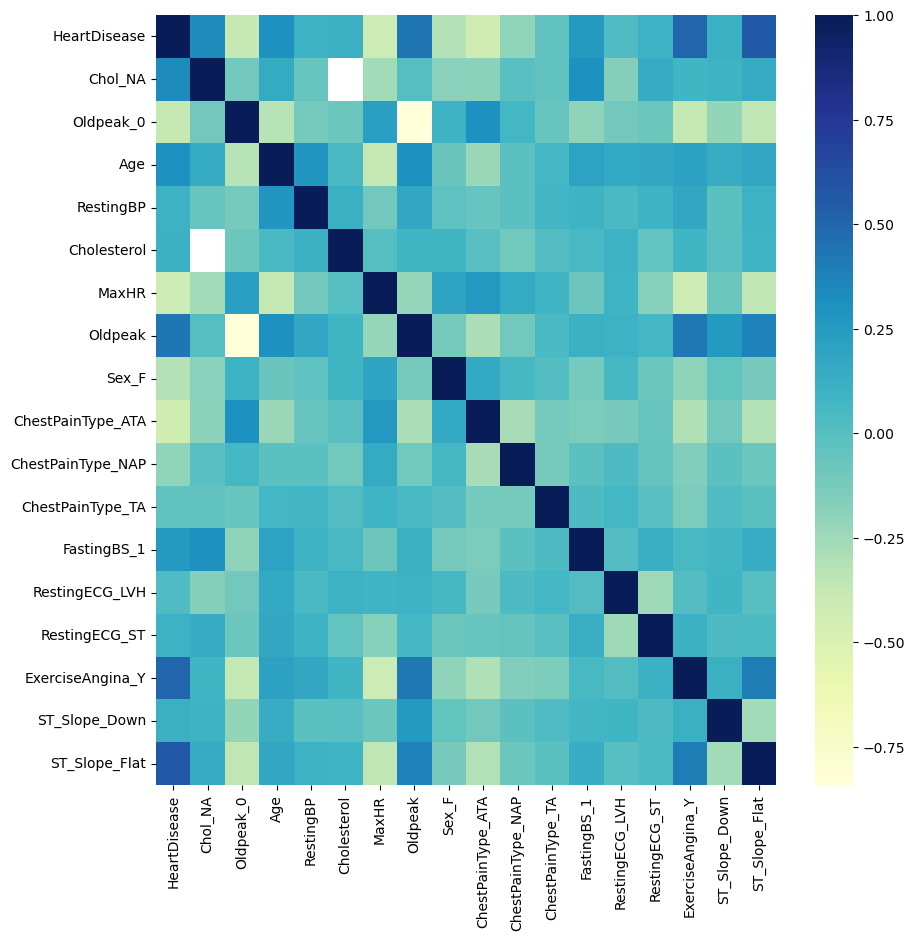

In [22]:
## compute rank correlations
train_eda = train_proc_1.drop(default_vars, axis=1, inplace=False)

rk_corr = train_eda.corr(method="spearman")
print("Rank correlation:")
plt.figure(figsize=(10, 10))
sns.heatmap(rk_corr, cmap="YlGnBu")

In [23]:
## significant rank correlations (|r|>0.4)
sig_corr = rk_corr[abs(rk_corr)>0.4]
sig_corr.replace(np.nan, "-", inplace=True)
sig_corr

,HeartDisease,Chol_NA,Oldpeak_0,Age,RestingBP,Cholesterol,MaxHR,Oldpeak,Sex_F,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,FastingBS_1,RestingECG_LVH,RestingECG_ST,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat
HeartDisease,1.0,-,-,-,-,-,-0.413251,0.436762,-,-0.42536,-,-,-,-,-,0.502205,-,0.566768
Chol_NA,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-
Oldpeak_0,-,-,1.0,-,-,-,-,-0.841144,-,-,-,-,-,-,-,-,-,-
Age,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-
RestingBP,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-,-
Cholesterol,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-,-,-,-
MaxHR,-0.413251,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-0.410103,-,-
Oldpeak,0.436762,-,-0.841144,-,-,-,-,1.0,-,-,-,-,-,-,-,0.417747,-,-
Sex_F,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-,-
ChestPainType_ATA,-0.42536,-,-,-,-,-,-,-,-,1.0,-,-,-,-,-,-,-,-


**Conclusions**:
*   The plots and rank correlations suggest *HeartDisease* has a  strong positive association with *Oldpeak*, *ExerciseAngina = "Y"*, and *ST_Slope = "Flat"*.
*    Strong negative associations can be seen with *MaxHR* and *ChestPainType = "ATA"*.
*   Some features are also highly correlated. For example, *ExerciseAngina = "Y"* & *Oldpeak* are significantly positively associated, while *ExerciseAngina* & *MaxHR*, *Oldpeak* & *ST_Slope = "Up"*, and *ExerciseAngina = "Y"* & *ST_Slope = "Up"* are significantly negatively correlated.

**Conclusions**:
*    When interpreting feature selection outputs, one needs to be cautious due to correlated predictors.

## **Q2: Logistic Lasso Regression**

For the purposes of modelling, the further preprocessing pipeline consists of the following steps:

*   For categorical features:
  1.  Keep dummy variables for *each* category

*  For continuous features
  2.   Impute missing values (incl. unrealistic 0 values) with the mean
  3.   Standardize to mean 0 and standard deviation 1
  4.   Create dummy variable for *Cholesterol = 0* and *Oldpeak = 0*

Justification:
 1.   Below, we use group lasso to penalize the inclusion of entire variables, not specific dummies.
 1.   Avoids having to throw away data; mean imputation is simple, understandable, and for the current purposes likely sufficient
 2.   Standardization ensures variable selection is independent of scale.
 3.   The fact of a data point missing migh itself be informative.

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# copy df
train_proc_2 = train_proc_1.copy()
test_proc_2 = test_proc_1.copy()

dummy_ft_names = train_proc_2.drop("HeartDisease", axis=1).columns.tolist()

# determine scaling & imputation strategy
scaler = StandardScaler()
imputer = SimpleImputer(strategy="mean")

# standardize features (according to training set)
train_proc_2 = scaler.fit_transform(train_proc_1.drop("HeartDisease", axis=1))
test_proc_2 = scaler.transform(test_proc_1.drop("HeartDisease", axis=1))

# impute missing values
train_proc_2 = imputer.fit_transform(train_proc_2)
test_proc_2 = imputer.transform(test_proc_2)

# put back to pandas
train_proc_2 = pd.DataFrame(train_proc_2, columns=dummy_ft_names)
test_proc_2 = pd.DataFrame(test_proc_2, columns=dummy_ft_names)

# add back label column
train_proc_2 = pd.concat([train_data["HeartDisease"], train_proc_2], axis=1)
test_proc_2 = pd.concat([test_data["HeartDisease"], test_proc_2], axis=1)

# make HeartDisease integer
train_proc_2["HeartDisease"] = train_proc_2["HeartDisease"].astype("int64")
test_proc_2["HeartDisease"] = test_proc_2["HeartDisease"].astype("int64")

In [25]:
X_train = train_proc_2.drop("HeartDisease", axis=1)
X_test = test_proc_2.drop("HeartDisease", axis=1)

y_train = train_proc_2["HeartDisease"]
y_test = test_proc_2["HeartDisease"]

When using regularization, we need to account for the fact that we introduced dummy variables. Specifically, we want to regularize the inclusion of entire variables, e.g. "Sex", and not certain categories, e.g. "Female", as this would introduce bias depending on the default category. To tackle this, we purposefully introduce all categories of categorical variables again and use **Group Lasso**. Altough this usually introduces multicollinearity, regularization serves to deal with this.

We fix "l1_reg" at 0 and choose "group_reg" through cross-validation, since we want to do selection of *groups* of variables, but do not want to encourage sparsity within groups.

In [26]:
#!pip install group-lasso  # has to be uncommented if not installed
from group_lasso import LogisticGroupLasso

group_names = ["Chol_NA", "Oldpeak_0", "Age", "RestingBP", "Cholesterol", "MaxHR", "Oldpeak",
               "Sex", "ChestPain", "FastingBS", "RestingECG", "ExerciseAngina",
               "ST_Slope"]
group_sizes = [1, 1, 1, 1, 1, 1, 1,
               2, 4, 2, 3, 2, 3]
n_groups = len(group_sizes)
groups = np.concatenate([size * [i] for i, size in enumerate(group_sizes)])

In [27]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score

p1_vals = 2.0**np.arange(-10, 0)
scores = []

for i in range(len(p1_vals)):
  lgl = LogisticGroupLasso(
      groups = groups,
      group_reg = p1_vals[i],
      l1_reg = 0.0,
      scale_reg = "inverse_group_size",
      subsampling_scheme = 1,
      supress_warning = True)

  result = cross_validate(lgl, X_train, y_train, scoring="f1", cv=5)
  score = result["test_score"].mean()
  scores.append(score)

p1_opt = p1_vals[np.argmax(scores)]
print("Optimal group penalty:", p1_opt)

Optimal group penalty: 0.015625


In [28]:
## fit model
lgl = LogisticGroupLasso(
    groups = groups,
    group_reg = p1_opt,
    l1_reg = 0.0,
    scale_reg = "inverse_group_size",
    subsampling_scheme = 1,
    supress_warning = True)

lgl.fit(X_train, y_train)

LogisticGroupLasso(group_reg=0.015625,
                   groups=array([ 0,  1,  2,  3,  4,  5,  6,  7,  7,  8,  8,  8,  8,  9,  9, 10, 10,
       10, 11, 11, 12, 12, 12]),
                   l1_reg=0.0, scale_reg='inverse_group_size',
                   subsampling_scheme=1, supress_warning=True)

## Model performance

              precision    recall  f1-score   support

        HD=0       0.85      0.74      0.79        74
        HD=1       0.84      0.91      0.87       110

    accuracy                           0.84       184
   macro avg       0.84      0.83      0.83       184
weighted avg       0.84      0.84      0.84       184



Text(0, 0.5, 'True Positive Rate')

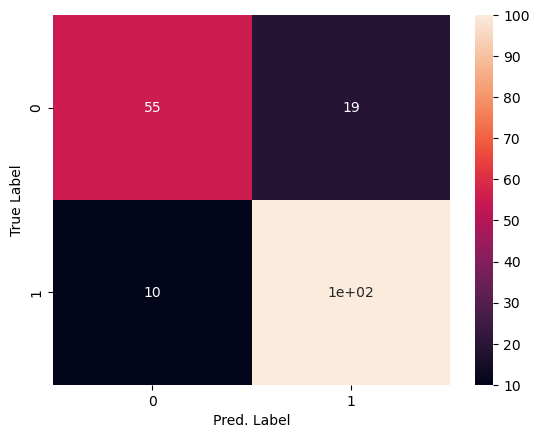

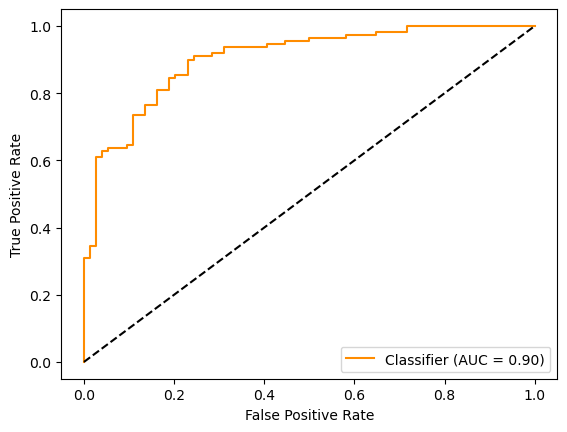

In [29]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import RocCurveDisplay

## get predicted probabilities and labels of HeartDisease
y_pred_prob = lgl.predict_proba(X_test)[:,1]
y_pred = lgl.predict(X_test)

# precision, recall, f1, ...
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"]))

# confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(conf_mat, annot=True)
plt.xlabel("Pred. Label")
plt.ylabel("True Label")

# ROC curve
RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_prob,
    color = "darkorange",)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## Model Interpretation

Text(0.5, 1.0, '(Dummy) Variable Coefficients (original scale)')

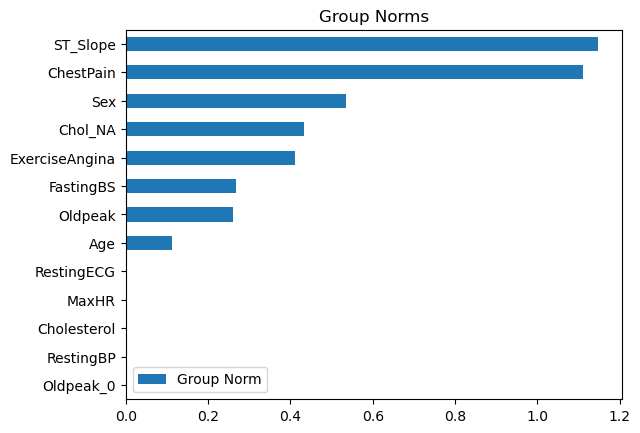

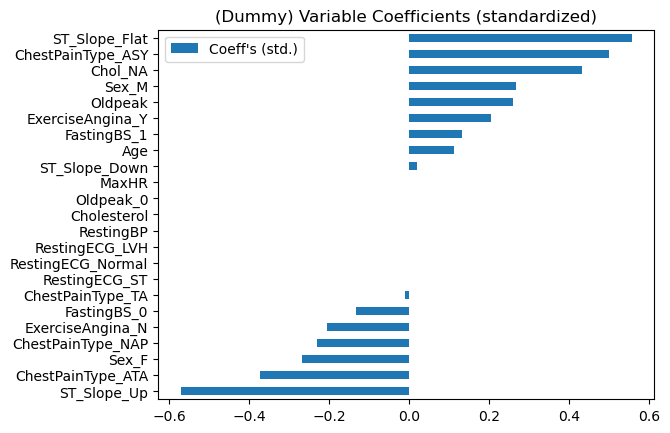

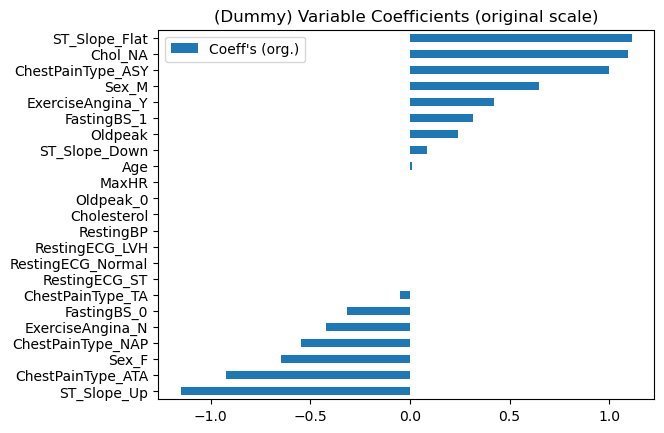

In [30]:
# get estimated coefficients
coeffs_std = lgl.coef_[:, 1] - lgl.coef_[:, 0]

# scale back to original scales
# (scale w/ sd but don't add mean)
scaler = StandardScaler(with_mean=False, with_std=True)
scaler.fit(train_proc_1.drop("HeartDisease", axis=1))

coeffs_org = np.reshape(coeffs_std, (1,len(coeffs_std)))
coeffs_org = scaler.transform(coeffs_org)
coeffs_org = np.reshape(coeffs_org, coeffs_std.shape)

# group norms
group_norms = np.array([[np.nan]]*n_groups)
for i in range(n_groups):
  group_coeffs = coeffs_std[groups==i]
  group_norms[i,:] = np.linalg.norm(group_coeffs, ord=1)
group_norms = np.reshape(group_norms, (13,))

# make pretty & plot
group_norms = pd.DataFrame({"Group Norm": group_norms},
                           index=group_names)
coeffs_std = pd.DataFrame({"Coeff's (std.)": coeffs_std},
                          index = ft_names)
coeffs_org = pd.DataFrame({"Coeff's (org.)": coeffs_org},
                          index = ft_names)
group_norms = group_norms.sort_values(by="Group Norm")
coeffs_std = coeffs_std.sort_values(by="Coeff's (std.)")
coeffs_org = coeffs_org.sort_values(by="Coeff's (org.)")

group_norms.plot.barh()
plt.title("Group Norms")
coeffs_std.plot.barh()
plt.title("(Dummy) Variable Coefficients (standardized)")
coeffs_org.plot.barh()
plt.title("(Dummy) Variable Coefficients (original scale)")

Our logistic regression classifier for heart disease prediction with group lasso regularization achieved an overall accuracy of 83%. Precision is 83% and recall/sensitivity is 90%, yielding an F1-score of 86%, while specificity is 73%. The AUC of the classifier is 0.90, which is well above the uninformed level of 0.50.

Group norms (of standardized coefficients) indicate (relative) **importance of variables**. In this case, *ST_Slope* and *ChestPain* offered the most predictive value for *HeartDisease*. After cross-validation, group lasso de-selected *RestingBP*, *Cholesterol*, *MaxHR*, and *RestingECG*, indicating that these offer no further predictive information about heart disease after accounting for the other variables.

The standardized coefficient estimates allow us to compare the **importance of specific categories**. For example, *ChestPain = "ATA"* and *ST_Slope = "Up"* seem to be strongly associated with heart disease than e.g. *ChestPain = "TA"* or *ST_Slope = "Down"*. We also find evidence that whether *Cholesterol* was 0 originally had predictive value for heart disease.

The original coefficient estimates allow us to infer the association between risk of heart disease and the variables in the *intuitive scales*. For example, we would expect the log-odds of *HeartDisease* to increase by $\approx 1.0$ for every additional year of age. Note that coefficients of dummy variables need to be interpreted *relative* to the other dummies. For example, *ST_Slope = "Flat"* increases the log-odds of *HeartDisease* by $\approx 0.3$, while *ST_Slope = "Up"* *decreases* it by $\approx 0.3$, and hence the log-odds of a patient with *ST_Slope = "Flat"* are about 0.6 higher than those of a patient with *ST_Slope = "Up"*.

We note that Lasso only selects variables relevant for prediction, and there is no guarantee of it identifying the *causal* variables. In our case, for example, although the estimate for *ST_Slope = "Up"* is significant, we saw above that it is significantly correlated with *ExerciseAngina*, and hence the latter might explain *HeartDisease* nearly as well.

## **Q3: Decision Tree**

For the decision tree, we still keep all dummies (any single category more easily accessible for tree), but do not standardize features.

In [31]:
# copy df
train_proc_3 = train_proc_1.copy()
test_proc_3 = test_proc_1.copy()

names = train_proc_3.columns.tolist()

# define imputation strategy
imputer = SimpleImputer(strategy="mean")

# impute missing values
train_proc_3 = imputer.fit_transform(train_proc_3)
test_proc_3 = imputer.transform(test_proc_3)

# put back to pandas
train_proc_3 = pd.DataFrame(train_proc_3, columns=names)
test_proc_3 = pd.DataFrame(test_proc_3, columns=names)

# make HeartDisease integer
train_proc_3["HeartDisease"] = train_proc_3["HeartDisease"].astype("int64")
test_proc_3["HeartDisease"] = test_proc_3["HeartDisease"].astype("int64")

In [32]:
X_train = train_proc_3.drop("HeartDisease", axis=1)
X_test = test_proc_3.drop("HeartDisease", axis=1)

y_train = train_proc_3["HeartDisease"]
y_test = test_proc_3["HeartDisease"]

all_dummy_names = X_train.columns

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree = DecisionTreeClassifier(criterion="gini",
                                random_state=1)

grid = {"max_depth": np.arange(1,8),
        "min_samples_leaf": 2**np.arange(0,7)
        }

cv = GridSearchCV(estimator=tree, param_grid=grid, scoring="f1", cv=5)
cv.fit(X_train, y_train)

opt_tree = cv.best_estimator_

print("Max. depth:", opt_tree.max_depth)
print("Min. samples per leaf:", opt_tree.min_samples_leaf)

Max. depth: 3
Min. samples per leaf: 8


Text(0.5, 1.0, 'Feature Importance Scores (Gini): Decision Tree')

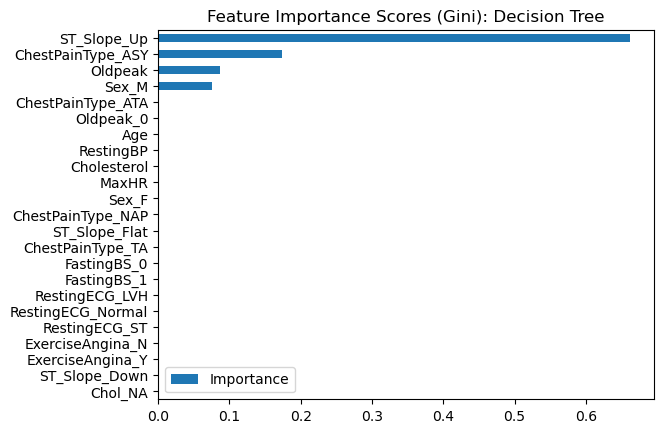

In [34]:
## feature importances

ft_importances = pd.DataFrame({"Importance": opt_tree.feature_importances_},
                              index = train_proc_3.drop("HeartDisease", axis=1).columns)

ft_importances = ft_importances.sort_values(by="Importance")
ft_importances = ft_importances
ft_importances.plot.barh()
plt.title("Feature Importance Scores (Gini): Decision Tree")

[Text(0.5, 0.875, 'ST_Slope_Up <= 0.5\ngini = 0.496\nsamples = 734\nvalue = [336, 398]\nclass = HD=1'),
 Text(0.25, 0.625, 'Sex_M <= 0.5\ngini = 0.295\nsamples = 412\nvalue = [74, 338]\nclass = HD=1'),
 Text(0.125, 0.375, 'ChestPainType_ASY <= 0.5\ngini = 0.5\nsamples = 68\nvalue = [34, 34]\nclass = HD=0'),
 Text(0.0625, 0.125, 'gini = 0.328\nsamples = 29\nvalue = [23, 6]\nclass = HD=0'),
 Text(0.1875, 0.125, 'gini = 0.405\nsamples = 39\nvalue = [11, 28]\nclass = HD=1'),
 Text(0.375, 0.375, 'ChestPainType_ASY <= 0.5\ngini = 0.206\nsamples = 344\nvalue = [40, 304]\nclass = HD=1'),
 Text(0.3125, 0.125, 'gini = 0.382\nsamples = 101\nvalue = [26, 75]\nclass = HD=1'),
 Text(0.4375, 0.125, 'gini = 0.109\nsamples = 243\nvalue = [14, 229]\nclass = HD=1'),
 Text(0.75, 0.625, 'ChestPainType_ASY <= 0.5\ngini = 0.303\nsamples = 322\nvalue = [262, 60]\nclass = HD=0'),
 Text(0.625, 0.375, 'Oldpeak <= 1.85\ngini = 0.11\nsamples = 223\nvalue = [210, 13]\nclass = HD=0'),
 Text(0.5625, 0.125, 'gini = 0.

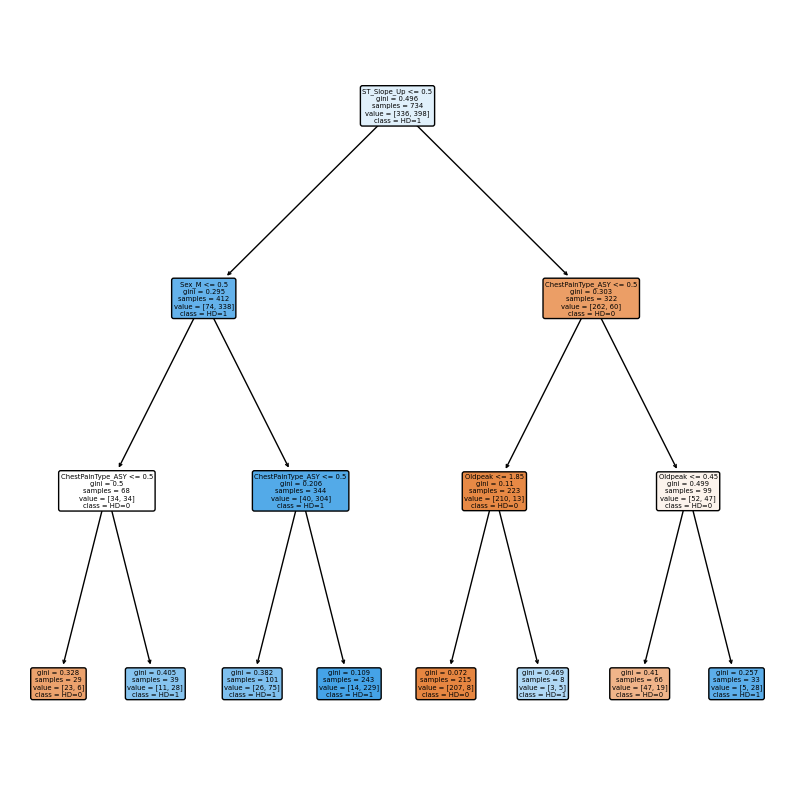

In [35]:
## inspect tree structure
from sklearn.tree import plot_tree

plt.figure(figsize=(10, 10))
plot_tree(opt_tree, feature_names=dummy_ft_names, class_names=["HD=0", "HD=1"],
          rounded=True, filled=True)

Similar to the case of Lasso, the automatic feature selection of decision trees becomes arbitrary if two or more features are highly correlated.

### Model performance

              precision    recall  f1-score   support

        HD=0       0.79      0.65      0.71        74
        HD=1       0.79      0.88      0.83       110

    accuracy                           0.79       184
   macro avg       0.79      0.77      0.77       184
weighted avg       0.79      0.79      0.78       184



Text(0, 0.5, 'True Positive Rate')

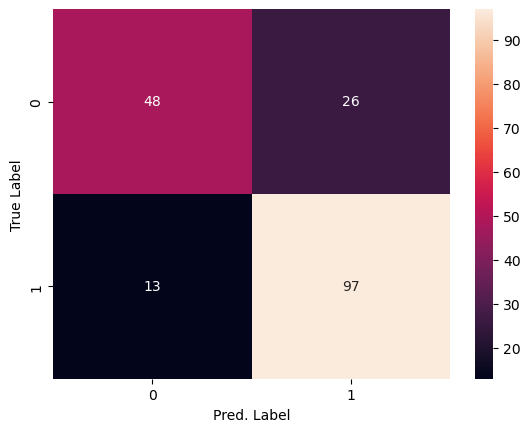

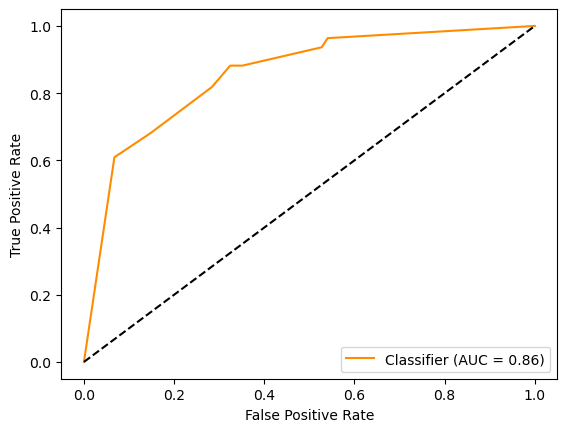

In [36]:
y_pred_prob = opt_tree.predict_proba(X_test)[:,1]
y_pred = opt_tree.predict(X_test)

# precision, recall, f1, ...
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"]))

# Export to latex
report = classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"], output_dict=True)
#report_df = pd.DataFrame(report).transpose()
#report_df.to_latex("tables/tree_report.tex")


# confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(conf_mat, annot=True)
plt.xlabel("Pred. Label")
plt.ylabel("True Label")

# ROC curve
RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_prob,
    color = "darkorange",)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

Overall, the decision tree only performs slightly worse than group lasso, despite it arguably being significantly more restricted (piecewise constant decision boundaries vs linear; 7 features used vs 16).

# **Q4: Multilayer Perception**

For the remaining models, we drop a default dummy variable to ease interpretation (see reference categories above)

In [37]:
# drop default dummy
train_proc_4 = train_proc_3.drop(default_vars, axis=1)
test_proc_4 = test_proc_3.drop(default_vars, axis=1)

X_train = train_proc_4.drop("HeartDisease", axis=1)
X_test = test_proc_4.drop("HeartDisease", axis=1)

y_train = train_proc_4["HeartDisease"]
y_test = test_proc_4["HeartDisease"]

red_dummy_names = X_train.columns

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange

In [71]:
#Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Defining Dataset
class HeartDiseaseDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Defining Model
class HeartDiseaseModel(nn.Module):
    def __init__(self, input_size, hidden_size, p_drop, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.drp1 = nn.Dropout(p=p_drop)
        self.drp2 = nn.Dropout(p=p_drop)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.sm  = nn.Sigmoid()

    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.drp1(x)
        x = self.relu2(self.fc2(x))
        x = self.drp2(x)
        x = self.fc3(x)
        x = self.sm(x)
        return x

In [82]:
# Defining Hyperparameters
input_size = X_train.shape[1]
hidden_size = 10
p_drop = 0.1
output_size = 1
batch_size = 32
num_epochs = 200

# Defining Dataloader
X = torch.tensor(X_train.values, dtype=torch.float)
y = torch.tensor(y_train.values, dtype=torch.float)
y = y.reshape(-1, 1)

dataset = HeartDiseaseDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Defining Model
model = HeartDiseaseModel(input_size, hidden_size, p_drop, output_size)

In [83]:
# Defining Loss Function and Optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Training
torch.manual_seed(0)
model.train()

for epoch in range(num_epochs+1):
  for batch_idx, (data, targets) in enumerate(dataloader):
    # Get data to cuda if possible
    data = data.to(device)
    targets = targets.to(device)

    # forward
    scores = model(data)
    loss = criterion(scores, targets)

    # backward
    optimizer.zero_grad()
    loss.backward()

    # gradient descent or adam step
    optimizer.step()

  if epoch % 10 == 0:
    y_pred = model(X)
    acc = np.mean(np.round(y_pred.detach().numpy())==y.detach().numpy())
    print("Ep.", epoch, "; Train Acc =", np.round(100*acc, 1), "%")

Ep. 0 ; Train Acc = 64.6 %
Ep. 10 ; Train Acc = 66.8 %
Ep. 20 ; Train Acc = 78.5 %
Ep. 30 ; Train Acc = 82.2 %
Ep. 40 ; Train Acc = 85.3 %
Ep. 50 ; Train Acc = 86.1 %
Ep. 60 ; Train Acc = 84.6 %
Ep. 70 ; Train Acc = 88.4 %
Ep. 80 ; Train Acc = 88.1 %
Ep. 90 ; Train Acc = 88.3 %
Ep. 100 ; Train Acc = 87.5 %
Ep. 110 ; Train Acc = 88.8 %
Ep. 120 ; Train Acc = 88.4 %
Ep. 130 ; Train Acc = 89.4 %
Ep. 140 ; Train Acc = 89.4 %
Ep. 150 ; Train Acc = 89.6 %
Ep. 160 ; Train Acc = 89.6 %
Ep. 170 ; Train Acc = 89.8 %
Ep. 180 ; Train Acc = 89.6 %
Ep. 190 ; Train Acc = 88.7 %
Ep. 200 ; Train Acc = 89.8 %


## Model Performance

              precision    recall  f1-score   support

        HD=0       0.83      0.73      0.78        74
        HD=1       0.83      0.90      0.86       110

    accuracy                           0.83       184
   macro avg       0.83      0.81      0.82       184
weighted avg       0.83      0.83      0.83       184



Text(0, 0.5, 'True Positive Rate')

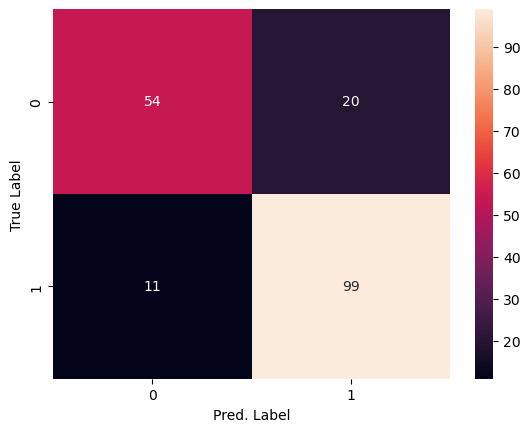

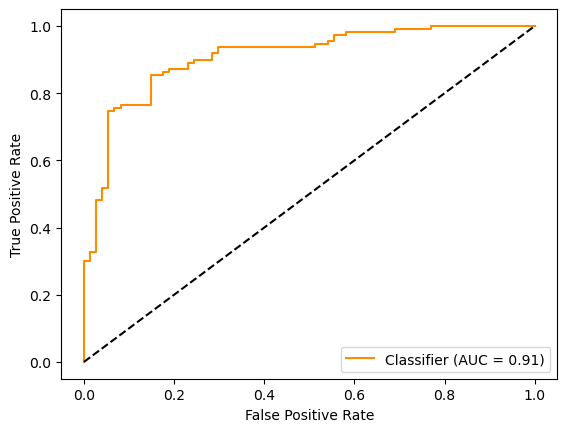

In [42]:
# Predicting
model.eval()
y_pred_prob = model(torch.tensor(X_test.values, dtype=torch.float)).detach().numpy()
y_pred = np.round(y_pred_prob)

# precision, recall, f1, ...
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"]))

# confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(conf_mat, annot=True)
plt.xlabel("Pred. Label")
plt.ylabel("True Label")

# ROC curve
RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_prob,
    color = "darkorange",)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### SHAP Values

Notes on the SHAP library and SHAP Values

- The calculation of the shap values is based on Monte Carlo sampling. You have to provide a "background dataset" from which the algorithm can take a random subsample to fill in the missing values that are not used in your coalition.
- The calculation works as follows: for a point x and feature of interest j do M iterations of
    1. Choose a random subset of features you want to have for coalition (in practice you can do this by random permutation of feature, then taking all features before j as fixed, replace the others)
	2. Randomly sample a datapoint z from the provided background dataset
	3. Replace all feature value in x that are not in coalition with values from z. 
	4. j+ the jth value from x, j- has value of j-th feature from z. $\phi^m_j = \hat{f}(x_{j+}) - \hat{f}(x_{j-})$ is unbiased estimator of shapley value of j the "additional contribution" of j-th feature.
    6. Repeat this M times to get an estimate of shapley value. $\phi_j = \frac{1}{M} \sum_{i=1}^M \phi^m_j$

- The input is a bit weird. You have to read in the docs (https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html) what it expects. I went with the DeepExplainer because it was built for pytorch/tensorflow models and was faster than the standard KernelExplainer. Also the docsite is not that good, not every API reference is linked so for newer ones like DeepKernel need to search in Google. But DeepExplainer has some weird bug as it does not give you the same output you get from your model, this post here explained the issue: https://github.com/slundberg/shap/issues/1678. The bug can be fixed by naming every moduel you use and not reusing them. 


Notes on Plots:

- The plots take an "expected value" as reference. This is basically how the outcome of a prediction is changed from the expected outcome because of a specific feature input. We get an expected value for each output of our model, which is 2 in our case (because two classes). This provides a good sanity check because the plots for class 0 and 1 should be "reversed" in some sense.

- The expected value depends on what you submit as a background dataset. The most realistic case for us is when you submit all your training data, which is why I chose DeepExplainer, it is a lot faster than the standard Kernel Explainer.

In [43]:
!pip install shap
import shap

In [44]:
# Using Deep Explainer
explainer = shap.DeepExplainer(model, torch.from_numpy(X_train.values).float())
shap_values = explainer.shap_values(torch.from_numpy(X_test.values).float())

In [45]:
# Expected Values (= Estimated Probability of class 1 if no feature is present) 
print("Expected Values: ", explainer.expected_value)

Expected Values:  [0.55264384]


In [46]:
# Visualizing all obs
shap.force_plot(explainer.expected_value, shap_values, X_test.values, feature_names=red_dummy_names)

In [47]:
# Prediction for obs 0
print("Prediction for obs 0: ", y_pred_prob[0])
print("Actual for obs 0: ", y_test[0])

# Plotting individual Shap Values of obs 0 class 0
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_test.values[0], feature_names=red_dummy_names)

Prediction for obs 0:  [0.94799715]
Actual for obs 0:  1


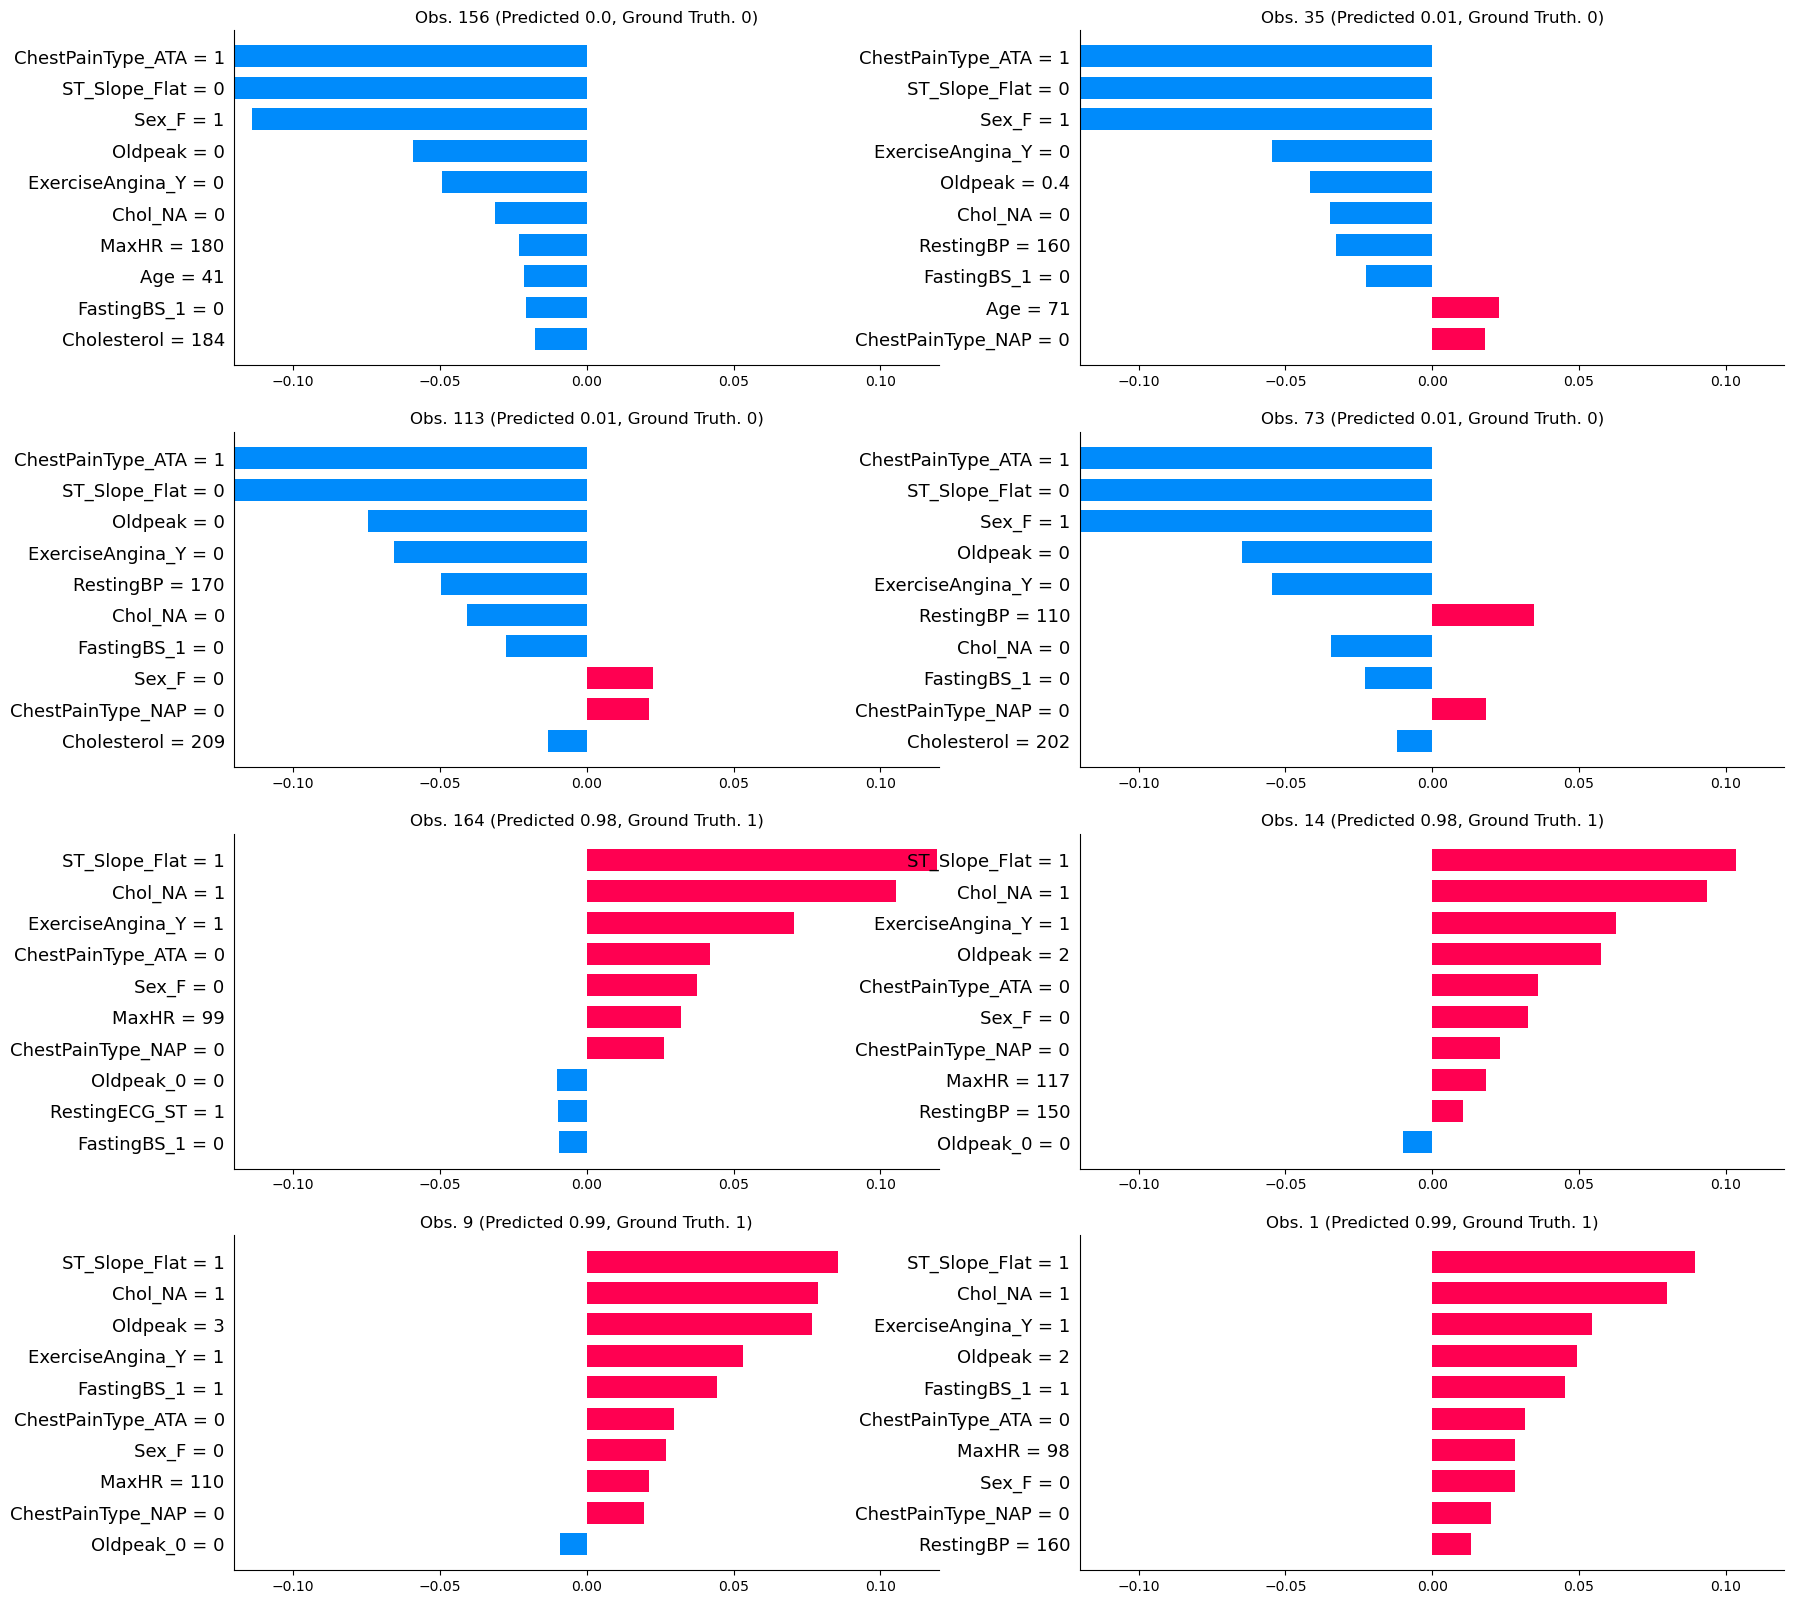

In [48]:
# Finding 4 positive and 4 negative obs
pos_obs = np.argsort(y_pred_prob[:,0])[:4]
neg_obs = np.argsort(y_pred_prob[:,0])[-4:]
ind = np.concatenate((pos_obs, neg_obs))

#fig, axs = plt.subplots(4, 2, figsize=(10, 10), squeeze=True)
plt.figure(figsize=(20, 20))

for i, obs in enumerate(ind):
    ax = plt.subplot(4, 2, i+1)
    ax.set_title("Obs. " + str(obs) + " (Predicted " + str(np.round(y_pred_prob[obs,0], 2)) + ", Ground Truth. " + str(y_test[obs]) + ")")
    shap.bar_plot(shap_values[obs], X_test.values[obs], feature_names=red_dummy_names, show=False, max_display=10)
    plt.xlabel("")
    plt.xlim(-0.12, 0.12)


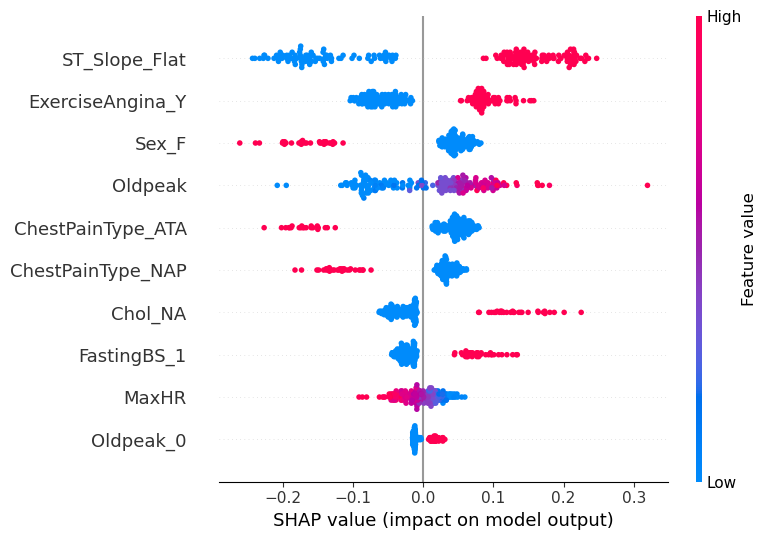

In [49]:
# Overall Feature Importance
shap.summary_plot(shap_values, X_test.values, feature_names=red_dummy_names, max_display=10, show=False)



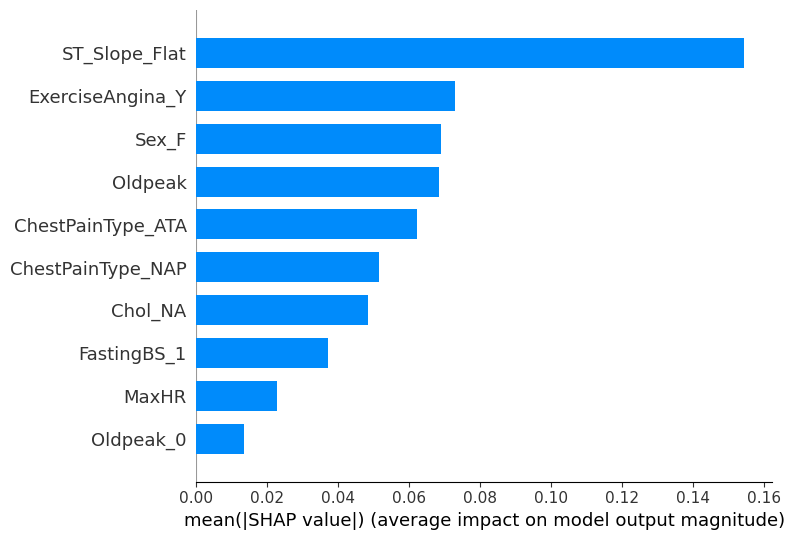

In [50]:
# Overall Feature Importance Bar Plot
shap.summary_plot(shap_values, X_test.values, feature_names=red_dummy_names, plot_type="bar", max_display=10)

### Interpretation

From the expected value of the class (averaged probability of belonging to that class) we see how each feature of an observation contributes to the end prediction in PLot 1. For example for the first observation it seems that the feature cat_ST_Slope_Up = 1 drove the probability for class 1 down, and for class 0 up. This is also reflected in the second summary plot, where we see that over all observations for which we calculated shapley values (first 100) the feature cat_ST_Slope_Up = 1 drove the prediction of class 1 down and the feature cat_ST_Slope_Up = 0 drove the prediction of class 1 up.

Model might be a bit underconfident? But with the colors hard to tell atm.

## **Challenge 1: Neural Additive Models**

The following was adapted from the following tutorial:

https://towardsdatascience.com/interpretable-neural-networks-with-pytorch-76f1c31260fe

***Step 1:*** we define a so called "block layer", which creates "n_blocks" different *unconnected* blocks. Since we want to keep all features fully separate, we intend to set *n_blocks* to the no. of features.

In [51]:
class BlockLinear(torch.nn.Module):
    def __init__(self, n_blocks, in_features, out_features):
        super().__init__()
        self.n_blocks = n_blocks
        self.in_features = in_features
        self.out_features = out_features
        self.block_weights = []
        self.block_biases = []
        for i in range(n_blocks):
            block_weight = torch.Tensor(out_features, in_features)
            block_weight = torch.nn.Parameter(block_weight)
            torch.nn.init.kaiming_uniform_(block_weight)
            self.register_parameter(
                f'block_weight_{i}',
                block_weight
            )
            self.block_weights.append(block_weight)
            block_bias = torch.Tensor(out_features)
            block_bias = torch.nn.Parameter(block_bias)
            bound = 1 / math.sqrt(in_features)
            torch.nn.init.uniform_(block_bias, -bound, bound)
            self.register_parameter(
                f'block_bias_{i}',
                block_bias
            )
            self.block_biases.append(block_bias)

    def forward(self, x):
        block_size = x.size(1) // self.n_blocks
        x_blocks = torch.split(
            x,
            split_size_or_sections=block_size,
            dim=1
        )
        block_outputs = []
        for block_id in range(self.n_blocks):
            block_outputs.append(
                x_blocks[block_id] @ self.block_weights[block_id].t() + self.block_biases[block_id]
            )
        return torch.cat(block_outputs, dim=1)

***Step 2:*** define model

In [52]:
class Model(torch.nn.Module):
    def __init__(self, width, p_drop):
        super().__init__()
        
        self.features = torch.nn.Sequential(
            BlockLinear(17, 1, width),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=p_drop),
            BlockLinear(17, width, width),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=p_drop),
            BlockLinear(17, width, width),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout(p=p_drop),
            BlockLinear(17, width, 1),
        )
        
        self.lr = torch.nn.Linear(17, 1)
        self.sm = torch.nn.Sigmoid()
        
    def forward(self, x):
        x = self.features(x)
        x = self.lr(x)
        x = self.sm(x)
        return x

***Step 3:*** train the model

In [53]:
## set model hyperparameters
width = 5
p_drop = 0.2

model = Model(width, p_drop)

In [54]:
X = torch.tensor(X_train.values, dtype=torch.float)
y = torch.tensor(y_train.values, dtype=torch.float)
y = y.reshape(-1, 1)

In [55]:
model.train() # put into training mode
torch.manual_seed(0)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.BCELoss()

for i in range(1000):
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred+1e-10, y)
    loss.backward()
    optimizer.step()
    if (i+1) % 100 == 0:
      acc = np.mean(np.round(y_pred.detach().numpy())==y.detach().numpy())
      print("Ep.", i+1, "; Train Acc =", np.round(100*acc, 1), "%")

Ep. 100 ; Train Acc = 61.2 %
Ep. 200 ; Train Acc = 81.1 %
Ep. 300 ; Train Acc = 80.5 %
Ep. 400 ; Train Acc = 83.9 %
Ep. 500 ; Train Acc = 82.3 %
Ep. 600 ; Train Acc = 83.8 %
Ep. 700 ; Train Acc = 83.8 %
Ep. 800 ; Train Acc = 84.7 %
Ep. 900 ; Train Acc = 85.8 %
Ep. 1000 ; Train Acc = 84.1 %


## Model Performance

              precision    recall  f1-score   support

        HD=0       0.81      0.76      0.78        74
        HD=1       0.84      0.88      0.86       110

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184



Text(0, 0.5, 'True Positive Rate')

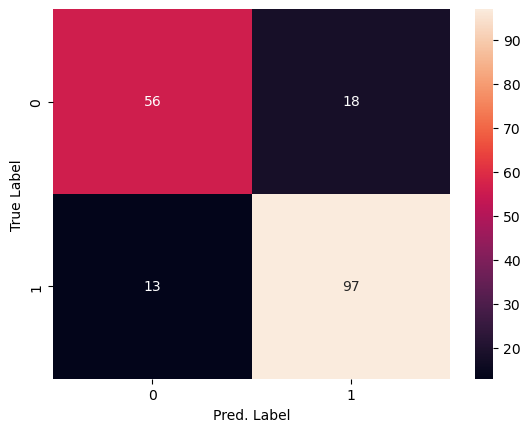

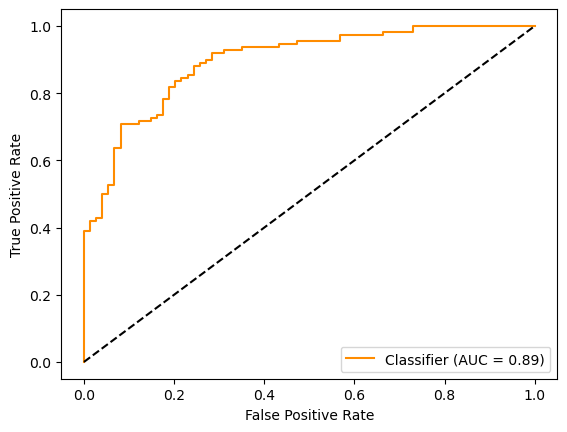

In [56]:
# get predictions
model.eval()
y_pred_prob = model(torch.tensor(X_test.values, dtype=torch.float)).detach().numpy()
y_pred = np.round(y_pred_prob)

# precision, recall, f1, ...
print(classification_report(y_true = y_test,
                            y_pred = y_pred,
                            target_names=["HD=0", "HD=1"]))

# confusion matrix
conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
sns.heatmap(conf_mat, annot=True)
plt.xlabel("Pred. Label")
plt.ylabel("True Label")

# ROC curve
RocCurveDisplay.from_predictions(
    y_true = y_test,
    y_pred = y_pred_prob,
    color = "darkorange",)
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

## Model Interpretation

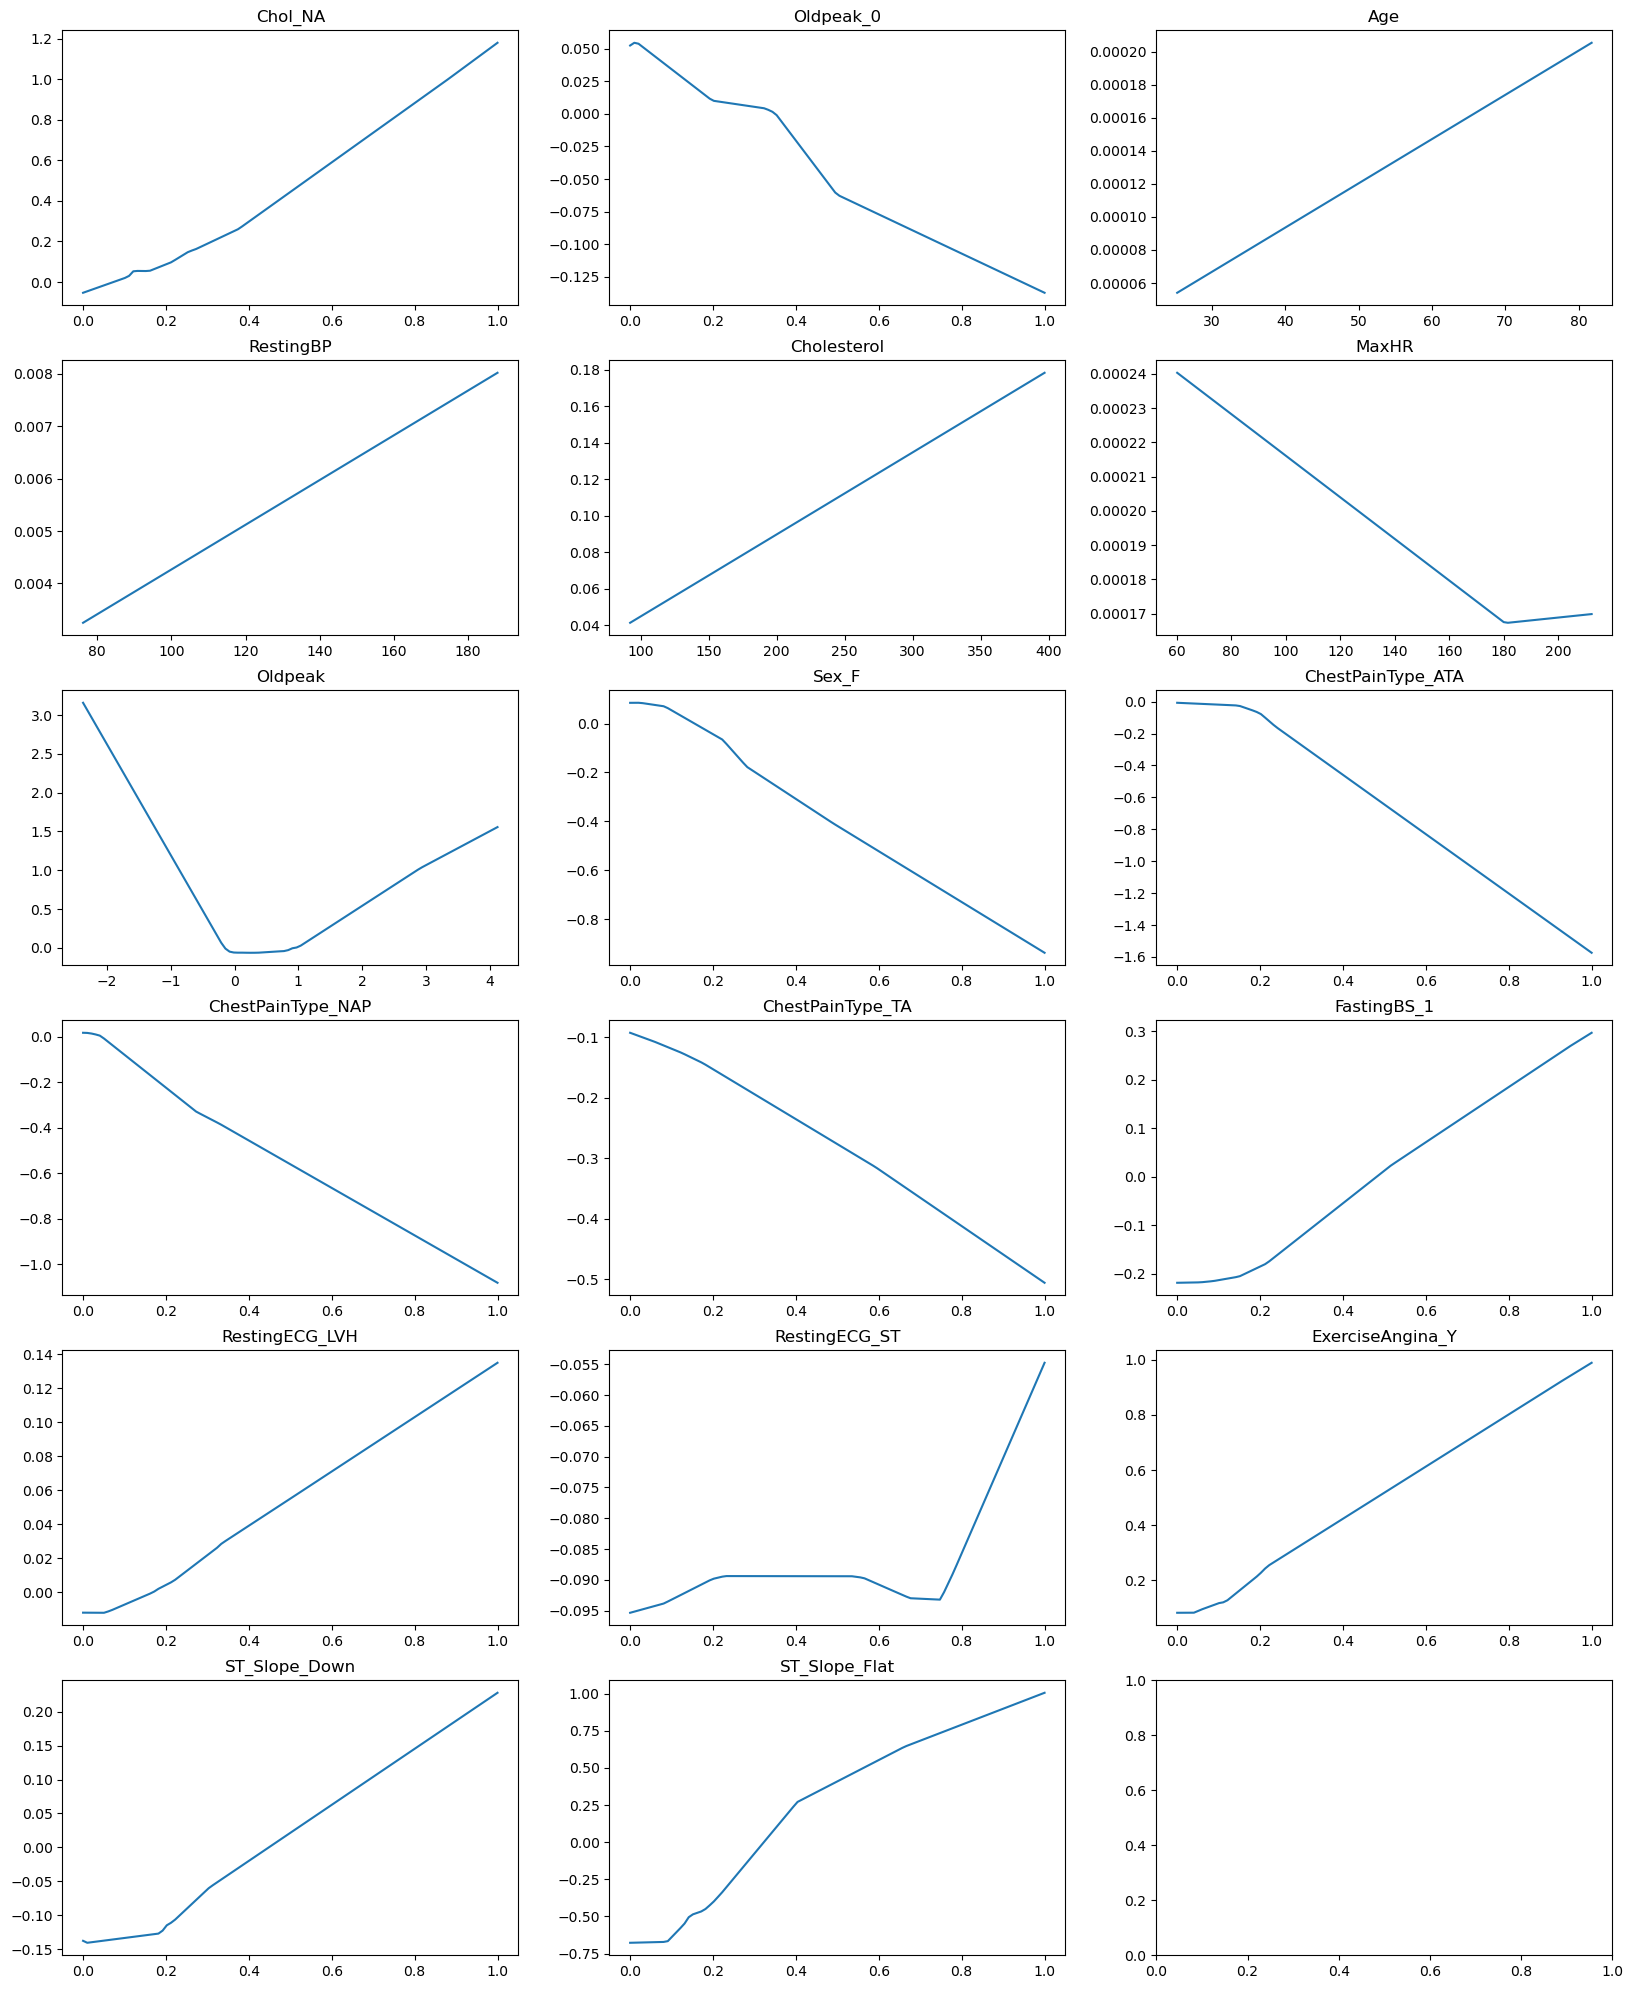

In [57]:
model.eval()

cat_dummy_names = [red_dummy_names[i] for i in range(len(red_dummy_names)) if red_dummy_names[i] not in num_fts]

if red_dummy_names[0] in cat_dummy_names:
    X = torch.linspace(0, 1, 100).reshape(-1, 1)
else:
  ft_mean = X_train.mean()[0]
  ft_sd = X_train.std()[0]
  X = torch.linspace(ft_mean-3*ft_sd, ft_mean+3*ft_sd, 100).reshape(-1, 1)

for i in range(1, len(red_dummy_names)):
  if red_dummy_names[i] in cat_dummy_names:
    x = torch.linspace(0, 1, 100).reshape(-1, 1)
  else:
    ft_mean = X_train.mean()[i]
    ft_sd = X_train.std()[i]
    x = torch.linspace(ft_mean-3*ft_sd, ft_mean+3*ft_sd, 100).reshape(-1, 1)
  
  X = torch.hstack([X, x])

fig, axs = plt.subplots(nrows=6, ncols=3, squeeze=True, figsize=(20, 25))

# Plotting feature values in 6 by 3 grid
axs = axs.flatten()

for i in range(len(red_dummy_names)):
  axs[i].plot(
      X[:, i].detach().numpy(),
      model.get_submodule('lr').weight[0][i].item() * model.get_submodule('features')(X)[:, i].detach().numpy()
      )
  axs[i].set_title(red_dummy_names[i])

Difference in log-odds for dummies:

Text(0.5, 1.0, 'Logit changes from categorical features')

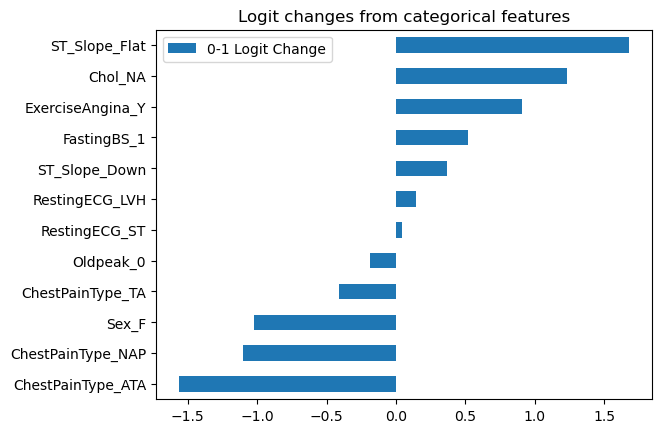

In [58]:
diff = np.array([np.nan]*len(red_dummy_names))

binary = torch.linspace(0, 1, 2).reshape(-1, 1)
binary = torch.hstack(len(red_dummy_names)*[binary])

for j in range(len(red_dummy_names)):
  diff[j] = model.get_submodule('lr').weight[0][j].item() * (model.get_submodule('features')(binary)[1,j].detach().numpy() - model.get_submodule('features')(binary)[0,j].detach().numpy())

cat_ind = [i for i in range(len(red_dummy_names)) if red_dummy_names[i] in cat_dummy_names]
diff = diff[cat_ind]
diff = pd.DataFrame(diff, columns=["0-1 Logit Change"], index=cat_dummy_names)
diff = diff.sort_values(by="0-1 Logit Change")

diff.plot.barh()
plt.title("Logit changes from categorical features")

Difference in logit from $\bar{x}_j-sd(x_j)$ to $\bar{x}_j+sd(x_j)$

Text(0.5, 1.0, 'Logit changes from mean–SD to mean+SD')

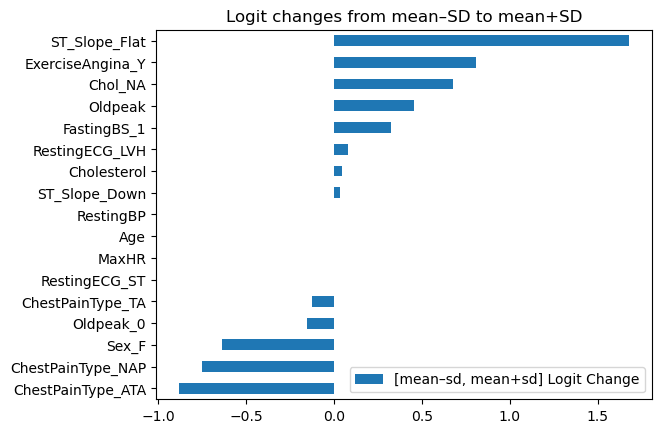

In [59]:
diff = np.array([np.nan]*len(red_dummy_names))

mean = X_train.mean()[0]
std = X_train.std()[0]
STD = torch.linspace(mean-std, mean+std, 2).reshape(-1, 1)

for j in range(1, X_train.shape[1]):
  mean = X_train.mean()[j]
  std = X_train.std()[j]
  new = torch.linspace(mean-std, mean+std, 2).reshape(-1, 1)
  STD = torch.hstack([STD, new])

for j in range(len(red_dummy_names)):
  diff[j] = model.get_submodule('lr').weight[0][j].item() * (model.get_submodule('features')(STD)[1,j].detach().numpy() - model.get_submodule('features')(STD)[0,j].detach().numpy())

diff = pd.DataFrame(diff, columns=["[mean–sd, mean+sd] Logit Change"], index=red_dummy_names)
diff = diff.sort_values(by="[mean–sd, mean+sd] Logit Change")

diff.plot.barh()
plt.title("Logit changes from mean–SD to mean+SD")

visualize feature importances of 4 positive & 4 negative samples

In [60]:
import random

# choose 4 positive samples with predicted probability > 0.9
pos_samples = train_proc_4.loc[train_proc_4["HeartDisease"] == 1, :].drop("HeartDisease", axis=1)
pos_probs = model(torch.tensor(pos_samples.values, dtype=torch.float)).detach().numpy()
pos_samples = pos_samples[pos_probs > 0.9].sample(4, random_state=1)

# choose 4 negative samples with predicted probability < 0.1
neg_samples = train_proc_4.loc[train_proc_3["HeartDisease"] == 0, :].drop("HeartDisease", axis=1)
neg_probs = model(torch.tensor(neg_samples.values, dtype=torch.float)).detach().numpy()
neg_samples = neg_samples[neg_probs < 0.1].sample(4, random_state=1)

pos_samples = torch.tensor(pos_samples.values, dtype=torch.float)
neg_samples = torch.tensor(neg_samples.values, dtype=torch.float)

In [61]:
pos_ft_imp = np.array([[np.nan]*4]*17)
neg_ft_imp = np.array([[np.nan]*4]*17)
for smpl in range(4):
  for ft in range(17):
    pos_ft_imp[ft, smpl] = model.get_submodule('lr').weight[0][ft].item() * model.get_submodule('features')(pos_samples)[smpl, ft].detach().numpy()
    neg_ft_imp[ft, smpl] = -model.get_submodule('lr').weight[0][ft].item() * model.get_submodule('features')(neg_samples)[smpl, ft].detach().numpy()

pos_ft_imp = pd.DataFrame(pos_ft_imp, index=red_dummy_names)
neg_ft_imp = pd.DataFrame(neg_ft_imp, index=red_dummy_names)

Text(0.5, 1.0, 'Negative Logit Contributions for Negative Samples')

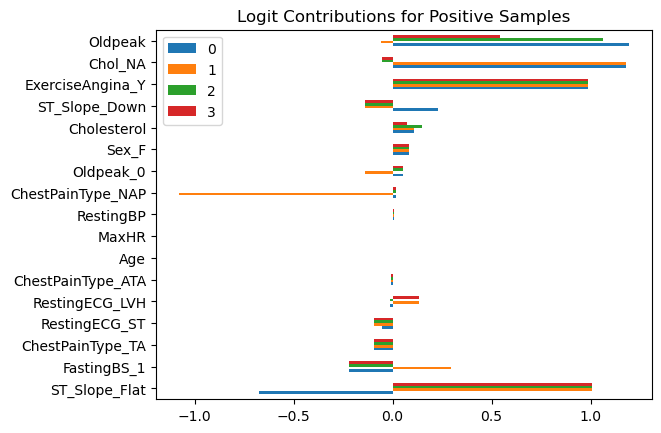

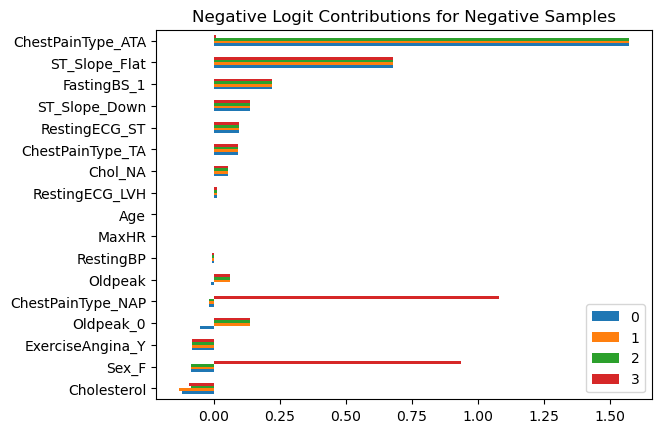

In [62]:
pos_ft_imp = pos_ft_imp.sort_values(by=0)
pos_ft_imp = pos_ft_imp
pos_ft_imp.plot.barh()
plt.title("Logit Contributions for Positive Samples")

neg_ft_imp = neg_ft_imp.sort_values(by=0)
neg_ft_imp = neg_ft_imp
neg_ft_imp.plot.barh()
plt.title("Negative Logit Contributions for Negative Samples")